# CNN Implementation #

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 14.0 MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras import backend as K
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import json
import warnings
import numpy as np
from scipy import signal, stats

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## With out K-fold or Feature extraction, use validation set only ##
Update: We are testing this method with W9 data

## load real dataset ##
Dont be sad if it does not fit, at least it is real
This dataset is for w11, contains mermaid : 0, jamesbond: 1, dab:2

In [ ]:
# data_folder_path_0 = os.path.join(os.getcwd(), 'w11_joshua_1')
# data_folder_path_1 = os.path.join(os.getcwd(), 'w11_joshua_2')
# data_folder_path_2 = os.path.join(os.getcwd(), 'w11_sanath_1')
# data_folder_path_3 = os.path.join(os.getcwd(), 'w11_michael_1')
# folders = glob(os.path.join(data_folder_path,'*.csv'))
# folders = glob(os.path.join(data_folder_path,'*.csv'))
# folders_2 = glob(os.path.join(data_folder_path_2,'*.csv'))
# folders_3 = glob(os.path.join(data_folder_path_3,'*.csv'))
activity_codes = {
  "mermaid":0,
  "jamesbond":1,
  "dab":2,
  "window360":3,
  "cowboy":4,
  "scarecrow":5,
  "pushback":6,
  "snake":7,
  "ultraman":8
}

activity_decodes = {
  0 : "mermaid",
  1 : "jamesbond",
  2 : "dab",
  3 : "window360",
  4 : "cowboy",
  5 : "scarecrow",
  6 : "pushback",
  7 : "snake",
  8 : "ultraman"
}
#usr_cols = ['attitude.roll','attitude.pitch','attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
activity_types = list(activity_codes.keys())

#hyper parameters
# window size is 3 s, sample rate 20 Hz
# Sliding window
window = 40
frequency = 20
cut_size_cand = 30
cut_front = 0
distinct_in_overlap = 10
overlap = int(((window - distinct_in_overlap) / window) * 100)
print(overlap)
#exponential moving average
ema = True
com = 2
#simple moving average
sma = False
sma_window = 3
# We need to skip the first trial
n_trials = 6
# We skip tial if it is less than the window length. How many we have?
skip_c = 0
# from col 1 to 6: Accelerometer x, y, z, yall, pitch, roll
usr_cols = ['1','2','3','4','5','6']
drop_cols = ['0', 'Unnamed: 0']
feature_n = 6

75


###  study data set ###

(6483, 8)
(6582, 8)


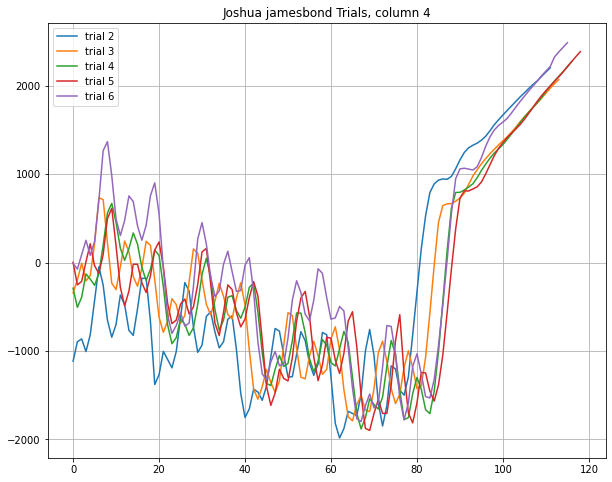

In [ ]:
test_data = pd.read_csv(os.path.join(data_folder_path, 'jamesbond_josh.csv'), index_col = False)
print(test_data.shape)
test_data_2 = pd.read_csv(os.path.join(data_folder_path_2, 'jamesbond_sanath.csv'), index_col = False)
print(test_data_2.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(2,7):
    temp = test_data[test_data['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['4'], label = f"trial {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('Joshua jamesbond Trials, column 4')
plt.legend()
ax.grid()
plt.show()

(6582, 8)


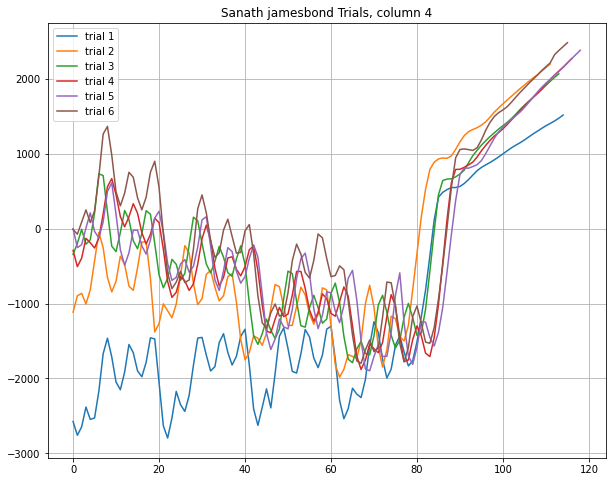

In [ ]:
test_data_2 = pd.read_csv(os.path.join(data_folder_path_2, 'jamesbond_sanath.csv'), index_col = False)
print(test_data_2.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(1,7):
    temp = test_data[test_data['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['4'], label = f"trial {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('Sanath jamesbond Trials, column 4')
plt.legend()
ax.grid()
plt.show()

(5498, 8)


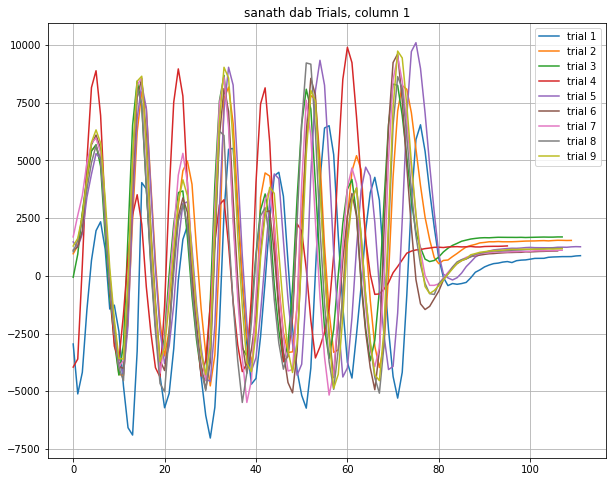

In [ ]:
test_data_3 = pd.read_csv(os.path.join(data_folder_path_2, 'dab_sanath.csv'), index_col = False)
print(test_data_3.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(1, 10):
    temp = test_data_3[test_data_3['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['1'], label = f"trial {str(i)}")

plt.title('sanath dab Trials, column 1')
plt.legend()
ax.grid()
plt.show()

(5413, 8)


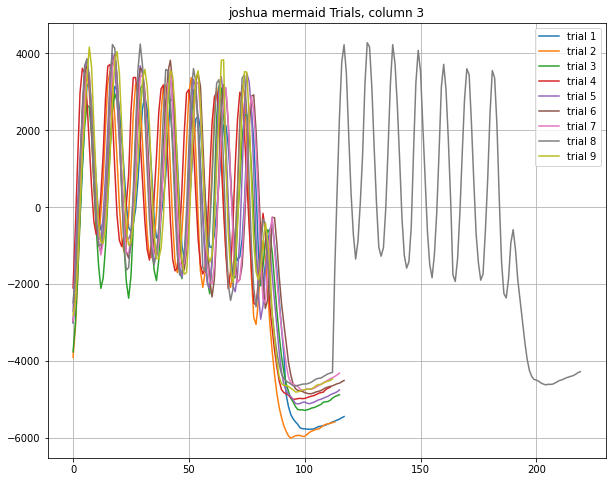

In [ ]:
test_data_4 = pd.read_csv('w11_joshua_3/mermaid.csv', index_col = False)
print(test_data_4.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(1,10):
    temp = test_data_4[test_data_4['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['3'], label = f"trial {str(i)}")

plt.title('joshua mermaid Trials, column 3')
plt.legend()
ax.grid()
plt.show()

### Load ###

In [ ]:
#start a new list
data_all_x_list = []
data_all_y_list = []

In [ ]:
def load_csv(folders, skip_c, ignore_dict=None):
    for filename in folders:
        label_name = filename.split('/')[-1].split('.')[0].split('_')[-1]
        # print(label_name)
        dancer = filename.split('/')[-1].split('.')[0].split('_')[0]
        # print(dancer)
        # if dancer != 'jerry':
        #   continue
        motion_df = pd.read_csv(filename, index_col = False)
        trial_end = motion_df['0'].max()
        trial_start = motion_df['0'].min()
        #print(f"motion_df's shape is : {motion_df.shape}")
        for i in range(trial_start, trial_end + 1):
            if (ignore_dict is not None) and (i in ignore_dict[label_name]):
                print(f"we skipped {i}")
                continue
            #print(f"we now work on {i}")
            df = motion_df[motion_df['0'] == i].copy()
            if df.empty:
              print(f"{filename} do not have trial {i}")
              continue
    #         drop_columns = list(set(df.columns) - set(usr_cols))
            df.drop(columns = drop_cols, inplace = True)
            length = df.shape[0]
            #print(f"initial shape {df.shape}")
            if length < window:
                print(f"{filename}, trial {i} has less than {window} samples")
                skip_c += 1
                continue
            # We cut the ending part, if we don't have enough, we dont cut
            cut_size = min(cut_size_cand, length - window)
            length -= cut_size
            df = df[0:length]
            # print(f"shape after cut tail: {df.shape}") 
            cut_front_size = min(cut_front, length - window)
            length -= cut_front_size
            df = df[cut_front_size:]
            # print(f"shape after cut front: {df.shape}") 

            # We apply MA filter here
            if ema:
                df = df.ewm(com = com).mean()
            if sma:
                df = df.rolling(window = sma_window).mean()

            #sliding window
            win_count = 1
            win_count += int((length - window)/ distinct_in_overlap)
            data_x = np.zeros((win_count, window, df.shape[1]))
            data_y = np.zeros(win_count)
            for c in range(win_count):
                start_idx = int(c * distinct_in_overlap)
                end_idx = start_idx + window
                data_x[c,:,:] = df[start_idx:end_idx].values
                data_y[:] = activity_codes[label_name]
            data_all_x_list.append(data_x)
            data_all_y_list.append(data_y)
    return skip_c

In [ ]:
#w13
data_folder_path = '/content/drive/MyDrive/w13'
folders = glob(os.path.join(data_folder_path,'*.csv'))
skip_c = load_csv(folders, skip_c)
print(len(data_all_x_list))
print(len(data_all_y_list))

/content/drive/MyDrive/w13/rh_2_pushback.csv, trial 8 has less than 40 samples
/content/drive/MyDrive/w13/zw_ultraman.csv, trial 49 has less than 40 samples
/content/drive/MyDrive/w13/zw_ultraman.csv do not have trial 50
/content/drive/MyDrive/w13/jerry_4_cowboy.csv, trial 7 has less than 40 samples
/content/drive/MyDrive/w13/jerry_3_cowboy.csv do not have trial 17
/content/drive/MyDrive/w13/jerry_2_window360.csv do not have trial 38
/content/drive/MyDrive/w13/jerry_2_ultraman.csv do not have trial 33
/content/drive/MyDrive/w13/rh_8_window360.csv, trial 6 has less than 40 samples
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 8
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 11
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 13
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 18
1144
1144


In [ ]:
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape) 
print(f"we skipped {skip_c} trials")

(12381, 40, 6)
(12381,)
we skipped 4 trials


In [ ]:
count = {
  0 : 0,
  1 : 0,
  2 : 0,
  3 : 0,
  4 :0,
  5 :0,
  6 : 0,
  7 : 0,
  8 : 0
}
for i in data_all_y:
  count[i] += 1
print(count)

{0: 1202, 1: 1468, 2: 905, 3: 1285, 4: 962, 5: 2003, 6: 1916, 7: 891, 8: 1749}


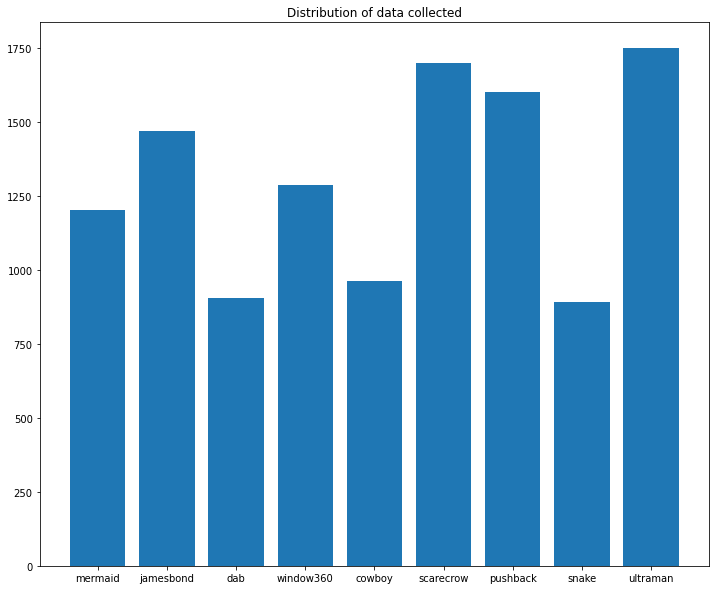

In [ ]:
fake = {0: 1202, 1: 1468, 2: 905, 3: 1285, 4: 962, 5: 1700, 6: 1600, 7: 891, 8: 1749}
fig, ax = plt.subplots(figsize = [12,10])
ax.bar(range(len(fake)), list(fake.values()), align='center')
plt.xticks(range(len(fake)), list(activity_codes.keys()))
plt.title("Distribution of data collected")
plt.show()

## What about dirrectly train with CNN? ##

In [ ]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

2165 602 241


In [ ]:
# Save test file to be test in ultra96 with tflite
print(test_x[20].shape)
_label = test_y[20]
print(_label)
with open('test_single_y.txt', 'w') as f:
    f.write('%d' % _label)
pd.DataFrame(test_x[20]).to_csv("test_single_x.csv", index = False)
#pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

(40, 6)
1


In [ ]:
num_classes = 3
input_shape = (window, 6)
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=num_classes), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=num_classes), dtype=tf.float32)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [ ]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(16, 40, 6)
(16, 3)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(input_shape = input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 38, 32)            608       
_________________________________________________________________
max_pooling1d_195 (MaxPoolin (None, 19, 32)            0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 17, 32)            3104      
_________________________________________________________________
max_pooling1d_196 (MaxPoolin (None, 9, 32)             0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 7, 32)             3104      
_________________________________________________________________
max_pooling1d_197 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 128)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/50
136/136 [==============================] - 2s 6ms/step - loss: 1.1037 - accuracy: 0.3991 - val_loss: 0.9866 - val_accuracy: 0.5394
Epoch 2/50
136/136 [==============================] - 0s 4ms/step - loss: 1.0507 - accuracy: 0.4457 - val_loss: 0.9952 - val_accuracy: 0.4440
Epoch 3/50
136/136 [==============================] - 0s 4ms/step - loss: 1.0211 - accuracy: 0.4545 - val_loss: 0.9574 - val_accuracy: 0.4606
Epoch 4/50
136/136 [==============================] - 0s 4ms/step - loss: 0.9864 - accuracy: 0.4730 - val_loss: 0.9204 - val_accuracy: 0.5436
Epoch 5/50
136/136 [==============================] - 1s 4ms/step - loss: 0.9794 - accuracy: 0.4822 - val_loss: 0.9493 - val_accuracy: 0.4523
Epoch 6/50
136/136 [==============================] - 1s 4ms/step - loss: 1.0387 - accuracy: 0.4564 - val_loss: 1.0087 - val_accuracy: 0.4149
Epoch 7/50
136/136 [==============================] - 0s 4ms/step - loss: 1.0533 - accuracy: 0.4162 - val_loss: 0.9517 - val_accuracy: 0.4564
Epoch 

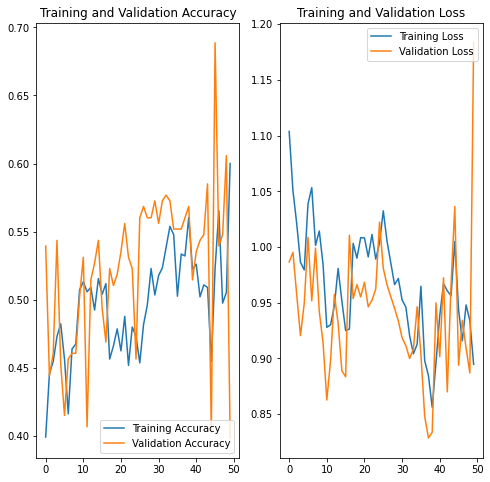

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(f"best training accruacy:{max(history.history['accuracy'])}")
print(f"best validation accruacy:{max(history.history['val_accuracy'])}")

best training accruacy:0.6000000238418579
best validation accruacy:0.6887966990470886


In [ ]:
# model.save('boing_cnn.h5')

In [ ]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

38/38 [==============================] - 0s 2ms/step - loss: 1.1129 - accuracy: 0.4352


[1.1129435300827026, 0.43521595001220703]

## What about K-fold cross validation? ##

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.15)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)
#how about we dont test? Just use K-fold cross validation, for train and val, and select the best
# train_x = data_all_x
# train_y = data_all_y
# print(train_x.shape)
# print(train_y.shape)

(10523, 40, 6) (1858, 40, 6)
(10523,) (1858,)


In [ ]:
# Save test file to be test in ultra96 with tflite
for i in range(len(test_y)):
  # print(test_x[20].shape)
  _label = test_y[i]
  # print(_label)
  with open(f"test/test_single_y_{window}_{i}.txt", 'w') as f:
      f.write('%d' % _label)
  pd.DataFrame(test_x[i]).to_csv(f"test/test_single_x_{window}_{i}.csv", index = False)

FileNotFoundError: ignored

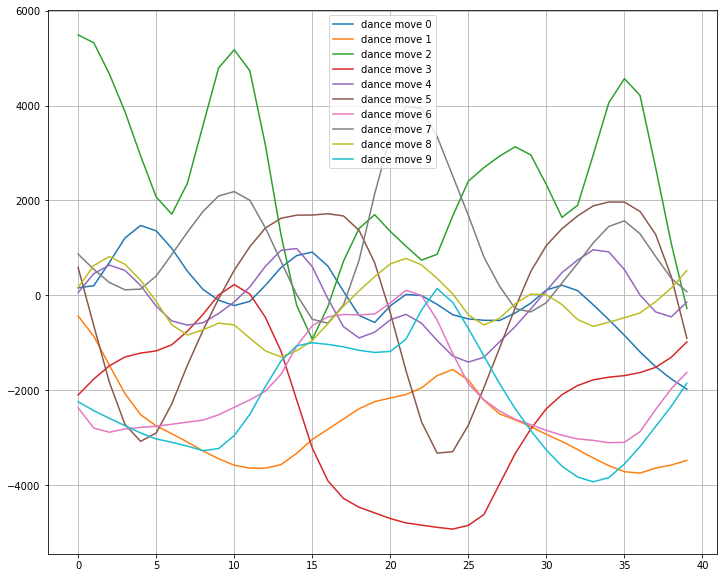

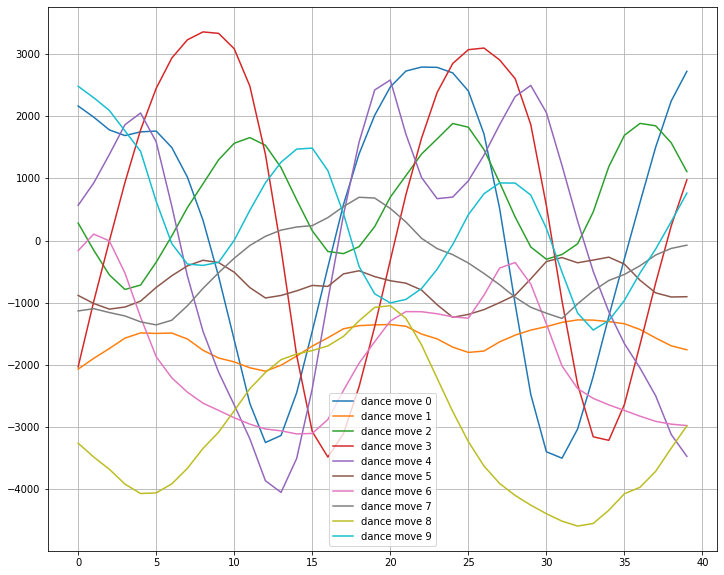

(10523, 40, 6) (1858, 40, 6)


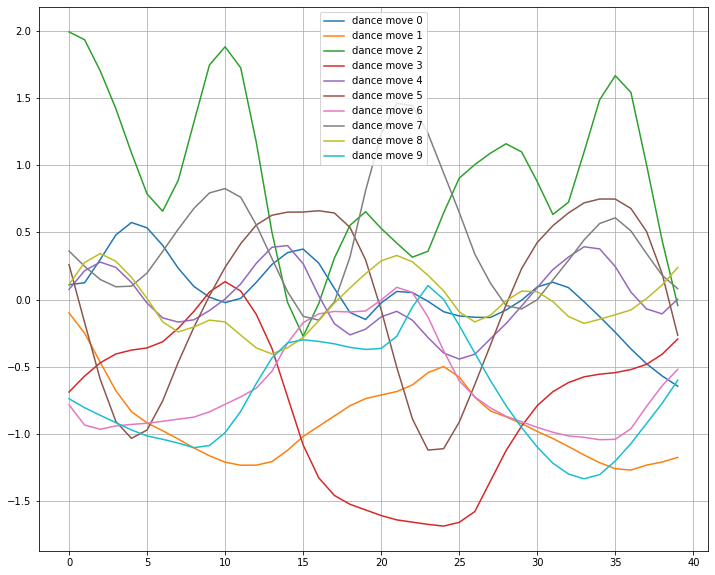

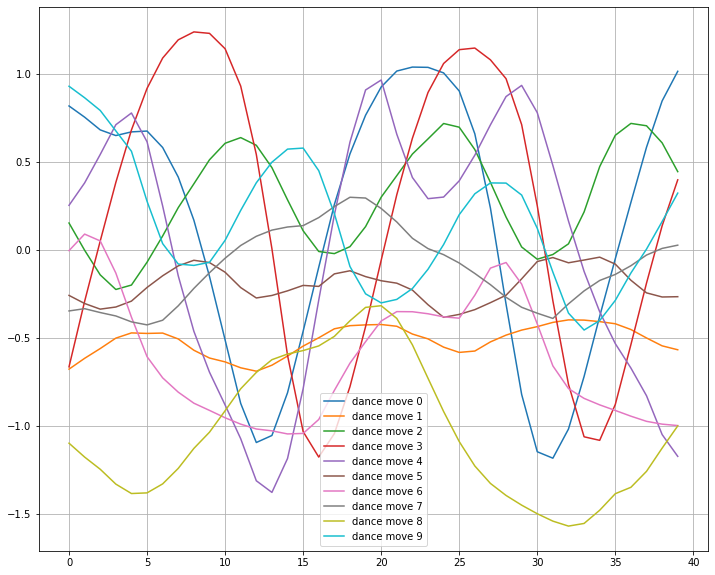

In [ ]:
#对比组
fig, ax = plt.subplots(figsize = [12,10])
for j in range(10):
  x = [i for i in range(len(train_x[j]))]
  ax.plot(x, train_x[j][:, 1], label = f"dance move {str(j)}")
plt.legend()
ax.grid()
plt.show()
fig, ax = plt.subplots(figsize = [12,10])
for j in range(10):
  x = [i for i in range(len(test_x[j]))]
  ax.plot(x, test_x[j][:, 1], label = f"dance move {str(j)}")
plt.legend()
ax.grid()
plt.show()

#sklearn组
from sklearn.preprocessing import StandardScaler
from pickle import dump
#feature_range=(-1,1)
scaler = StandardScaler()
# fit scaler on the training dataset
scaler.fit(train_x.reshape(-1, train_x.shape[-1]))
# transform the training dataset
train_x = scaler.transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
test_x = scaler.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)
print(train_x.shape, test_x.shape)
fig, ax = plt.subplots(figsize = [12,10])
for j in range(10):
  x = [i for i in range(len(train_x[j]))]
  ax.plot(x, train_x[j][:, 1], label = f"dance move {str(j)}")
plt.legend()
ax.grid()
plt.show()
fig, ax = plt.subplots(figsize = [12,10])
for j in range(10):
  x = [i for i in range(len(test_x[j]))]
  ax.plot(x, test_x[j][:, 1], label = f"dance move {str(j)}")
plt.legend()
ax.grid()
plt.show()
# dump(scaler, open('/content/drive/MyDrive/temp_models/scaler.pkl', 'wb'))

##方法1组
# train_x_2 = train_x /np.max(np.abs(train_x),axis=0)
# test_x_2 = test_x / np.max(np.abs(test_x),axis=0)

#方法2组
# shape_train = train_x.shape
# # print(shape_b)
# train_x = np.reshape(train_x, (-1, train_x.shape[-1]))
# train_max = np.array(train_x.max(axis=0))
# train_min = np.array(train_x.min(axis=0))
# print(train_x.min(axis=0))
# print(train_x.max(axis=0))
# print(train_max)
# print(train_min)
# # train_x_2 = np.copy(train_x)
# train_std = (train_x - train_x.min(axis=0)) / (train_x.max(axis=0) - train_x.min(axis=0))
# #X_scaled = X_std * (max - min) + min
# train_x = train_std * 1
# train_x = np.reshape(train_x, shape_train)

# shape_test = test_x.shape
# # print(shape_b)
# test_x = np.reshape(test_x, (-1,test_x.shape[-1]))
# # test_x_2 = np.copy(test_x)
# test_std = (test_x - train_min) / (train_max - train_min)
# test_x= test_std * 1
# test_x = np.reshape(test_x, shape_test)

# print(train_x.shape, test_x.shape)
# fig, ax = plt.subplots(figsize = [10,8])
# for j in range(20):
#   x = [i for i in range(len(train_x[j]))]
#   ax.plot(x, train_x[j][:, 1], label = str(j))
# plt.legend()
# ax.grid()
# plt.show()
# fig, ax = plt.subplots(figsize = [10,8])
# for j in range(20):
#   x = [i for i in range(len(test_x[j]))]
#   ax.plot(x, test_x[j][:, 1], label = str(j))
# plt.legend()
# ax.grid()
# plt.show()


0it [00:00, ?it/s]

===Highest training accuracy for fold 1: 0.969470202922821===
===Lowest training loss for fold 1: 2.026803731918335===


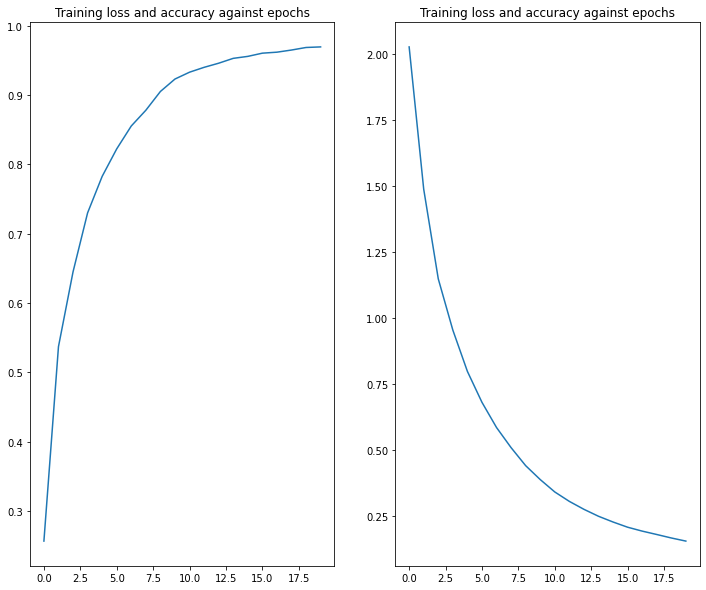

===Validation accuracy for fold 1: 0.9748218655586243; f1_macro is 0.9727904200553894===
===Highest training accuracy for fold 2: 0.969113826751709===
===Lowest training loss for fold 2: 2.270512104034424===


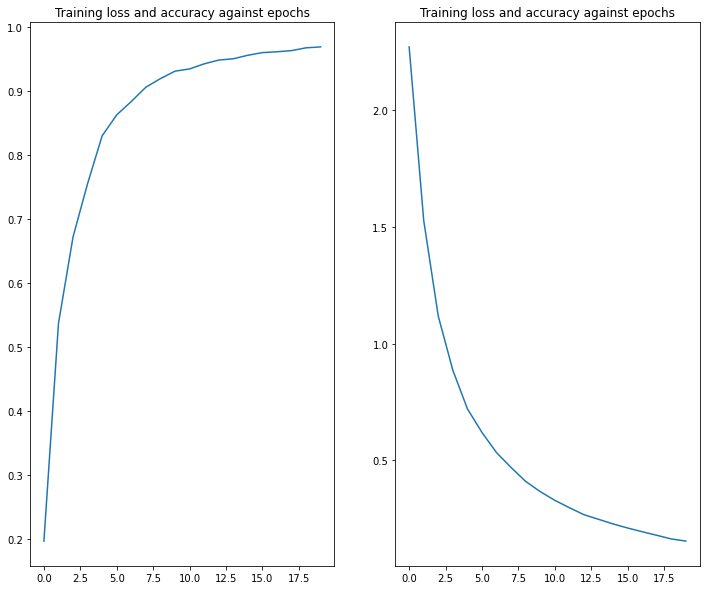

===Validation accuracy for fold 2: 0.967695951461792; f1_macro is 0.9629147052764893===
===Highest training accuracy for fold 3: 0.9836065769195557===
===Lowest training loss for fold 3: 2.129316806793213===


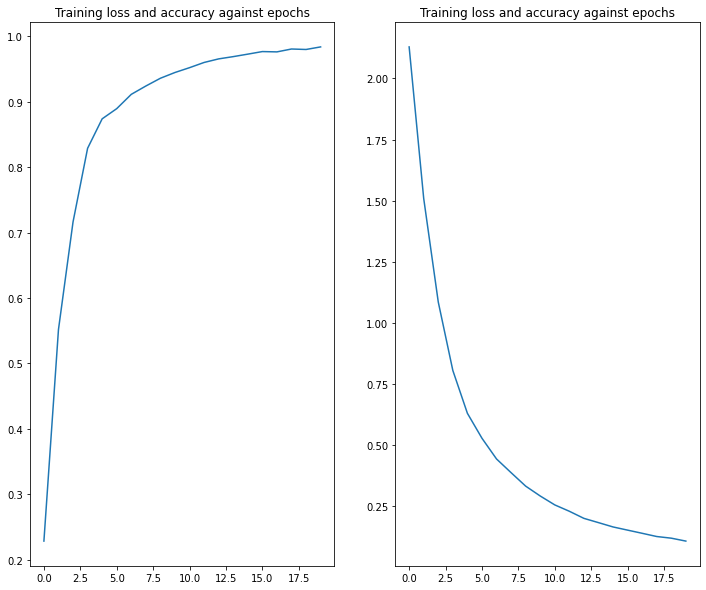

===Validation accuracy for fold 3: 0.978622317314148; f1_macro is 0.9759585857391357===
===Highest training accuracy for fold 4: 0.9802826642990112===
===Lowest training loss for fold 4: 2.1177425384521484===


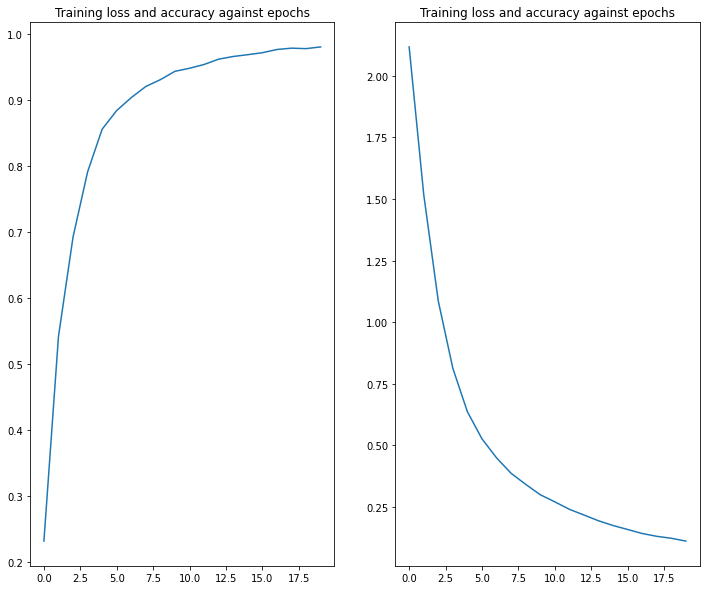

===Validation accuracy for fold 4: 0.980038046836853; f1_macro is 0.9781138896942139===
===Highest training accuracy for fold 5: 0.9769569039344788===
===Lowest training loss for fold 5: 2.089247465133667===


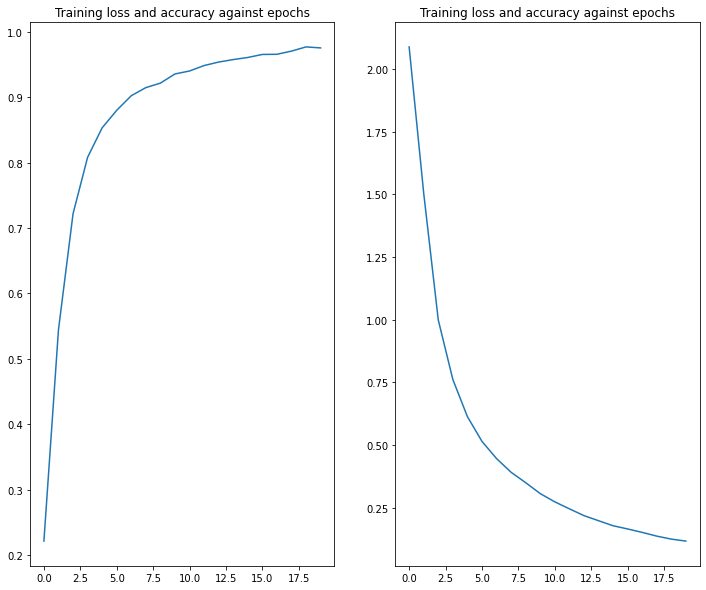

===Validation accuracy for fold 5: 0.9771863222122192; f1_macro is 0.974482536315918===
=== K fold cv completed, Best model occured at fold 4, with accuracy 0.980038046836853, f1 macro 0.9781138896942139===


In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
num_classes = 9
num_features = 6
batch_size = 32
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 20
best_id = 1
best_acc = 0
best_f1_macro = 0
input_shape = (window,6)
save_path = '/content/drive/MyDrive/temp_models'
print_frequency = 15

for train, test in tqdm(kfold.split(train_x, train_y)):
  with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = input_shape),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
#     print(_train_x.shape)
#     print(_train_y.shape)
#     print(_val_x.shape)
#     print(_val_y.shape)
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    #If feature extraction is used, then the input is 1d array, we need re format for cnn
#     _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
#     _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=num_classes), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes= num_classes), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs,
        verbose=0
    )
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    print(f"===Highest training accuracy for fold {fold_no}: {max(train_acc)}===")
    print(f"===Lowest training loss for fold {fold_no}: {max(train_loss)}===")
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize = [12,10])
    ax1.title.set_text("Training loss and accuracy against epochs")
    ax1.plot(train_acc)
    ax2.plot(train_loss)
    plt.title("Training loss and accuracy against epochs")
    plt.show()
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_f1_macro = f1_macro
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_kfold_fold{fold_no}.h5"))
    fold_no += 1
print(f"=== K fold cv completed, Best model occured at fold {best_id}, with accuracy {best_acc}, f1 macro {best_f1_macro}===")

In [ ]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
#Again, we conly need below line if feature extraction is used
#test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fold{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
for i in range(len(test_y)):
  if test_y[i] != y_pred_1[i]:
    print(test_y[i], y_pred_1[i])
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

5 4
5 8
5 2
6 1
6 4
5 1
test accuracy is 0.9967707395553589
test f1 macro is 0.9969321489334106


In [ ]:
print(best_id)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fold{best_id}.h5"))

4


In [ ]:
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 38, 32)            608       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 17, 32)            3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 6, 32)             3104      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 3, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 96)               

## What about feature extraction? ##

### load dataset using feature extraction ###

In [ ]:
def compute_mean(data):
    return np.mean(data)


def compute_variance(data):
    return np.var(data)


def compute_median_absolute_deviation(data):
    return stats.median_absolute_deviation(data)


def compute_root_mean_square(data):
    def compose(*fs):
        def wrapped(x):
            for f in fs[::-1]:
                x = f(x)
            return x

        return wrapped

    rms = compose(np.sqrt, np.mean, np.square)
    return rms(data)


def compute_interquartile_range(data):
    return stats.iqr(data)


def compute_percentile_75(data):
    return np.percentile(data, 75)


def compute_kurtosis(data):
    return stats.kurtosis(data)


def compute_min_max(data):
    return np.max(data) - np.min(data)


def compute_signal_magnitude_area(data):
    return np.sum(data) / len(data)


def compute_zero_crossing_rate(data):
    return ((data[:-1] * data[1:]) < 0).sum()


def compute_spectral_centroid(data):
    spectrum = np.abs(np.fft.rfft(data))
    normalized_spectrum = spectrum / np.sum(
        spectrum
    )  # like a probability mass function
    normalized_frequencies = np.linspace(0, 1, len(spectrum))
    spectral_centroid = np.sum(normalized_frequencies * normalized_spectrum)
    return spectral_centroid


def compute_spectral_entropy(data):
    freqs, power_density = signal.welch(data)
    return stats.entropy(power_density)


def compute_spectral_energy(data):
    freqs, power_density = signal.welch(data)
    return np.sum(np.square(power_density))


def compute_principle_frequency(data):
    freqs, power_density = signal.welch(data)
    return freqs[np.argmax(np.square(power_density))]

In [ ]:
def load_csv_fx(folders, skip_c, ignore_dict=None):
    for filename in folders:
        label_name = filename.split('/')[-1].split('.')[0].split('_')[-1]
        # print(label_name)
        dancer = filename.split('/')[-1].split('.')[0].split('_')[0]
        # print(dancer)
        # if dancer != 'jerry':
        #   continue
        motion_df = pd.read_csv(filename, index_col = False)
        trial_end = motion_df['0'].max()
        trial_start = motion_df['0'].min()
        #print(f"motion_df's shape is : {motion_df.shape}")
        for i in range(trial_start, trial_end + 1):
            if (ignore_dict is not None) and (i in ignore_dict[label_name]):
                print(f"we skipped {i}")
                continue
            #print(f"we now work on {i}")
            df = motion_df[motion_df['0'] == i].copy()
            if df.empty:
              print(f"{filename} do not have trial {i}")
              continue
    #         drop_columns = list(set(df.columns) - set(usr_cols))
            df.drop(columns = drop_cols, inplace = True)
            length = df.shape[0]
            #print(f"initial shape {df.shape}")
            if length < window:
                print(f"{filename}, trial {i} has less than {window} samples")
                skip_c += 1
                continue
                
            # We cut the ending part, if we don't have enough, we dont cut
            cut_size = min(cut_size_cand, length - window)
            length -= cut_size
            df = df[0:length]
            # print(f"shape after cut tail: {df.shape}") 
            cut_front_size = min(cut_front, length - window)
            length -= cut_front_size
            df = df[cut_front_size:]
            #print(f"shape after cut front: {df.shape}")    

            # We apply EMA filter here
            if ema:
                df = df.ewm(com = com).mean()
            if sma:
                df = df.rolling(window = sma_window).mean()
            #sliding window
            win_count = 1
            win_count += int((length - window)/ distinct_in_overlap)
            #print(win_count)
            data_x = np.zeros((win_count, df.shape[1] * 14))
            data_y = np.zeros(win_count)
            for c in range(win_count):
                start_idx = int(c * distinct_in_overlap)
                end_idx = start_idx + window
                temp_list = []
                for k in range(1, 1 + feature_n):
                    f_n = df[start_idx:end_idx][str(k)].to_numpy()
                    f_n = f_n.reshape(-1)
#                     print(f_n.shape)
                    f1_mean = compute_mean(f_n)
                    f1_var = compute_variance(f_n)
                    f1_mad = compute_median_absolute_deviation(f_n)
                    f1_rms = compute_root_mean_square(f_n)
                    f1_iqr = compute_interquartile_range(f_n)
                    f1_per75 = compute_percentile_75(f_n)
                    f1_kurtosis = compute_kurtosis(f_n)
                    f1_min_max = compute_min_max(f_n)
                    f1_sma = compute_signal_magnitude_area(f_n)
                    f1_zcr = compute_zero_crossing_rate(f_n)
                    f1_sc = compute_spectral_centroid(f_n)
                    f1_entropy = compute_spectral_entropy(f_n)
                    f1_energy = compute_spectral_energy(f_n)
                    f1_pfreq = compute_principle_frequency(f_n)
                    temp_list.append(f1_mean)
                    temp_list.append(f1_var)
                    temp_list.append(f1_mad)
                    temp_list.append(f1_rms)
                    temp_list.append(f1_iqr)
                    temp_list.append(f1_per75)
                    temp_list.append(f1_kurtosis)
                    temp_list.append(f1_min_max)
                    temp_list.append(f1_sma)
                    temp_list.append(f1_zcr)
                    temp_list.append(f1_sc)
                    temp_list.append(f1_entropy)
                    temp_list.append(f1_energy)
                    temp_list.append(f1_pfreq)
#                     print(temp_list)
                data_x[c] = temp_list
                data_y[c] = activity_codes[label_name]
            data_all_x_list.append(data_x)
            data_all_y_list.append(data_y)
    return skip_c

In [ ]:
#start a new list
data_all_x_list = []
data_all_y_list = []

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#w13
data_folder_path = '/content/drive/MyDrive/w13'
folders = glob(os.path.join(data_folder_path,'*.csv'))
skip_c = load_csv(folders, skip_c)
print(len(data_all_x_list))
print(len(data_all_y_list))

/content/drive/MyDrive/w13/rh_2_pushback.csv, trial 8 has less than 40 samples
/content/drive/MyDrive/w13/zw_ultraman.csv, trial 49 has less than 40 samples
/content/drive/MyDrive/w13/zw_ultraman.csv do not have trial 50
/content/drive/MyDrive/w13/jerry_4_cowboy.csv, trial 7 has less than 40 samples
/content/drive/MyDrive/w13/jerry_3_cowboy.csv do not have trial 17
/content/drive/MyDrive/w13/jerry_2_window360.csv do not have trial 38
/content/drive/MyDrive/w13/jerry_2_ultraman.csv do not have trial 33
/content/drive/MyDrive/w13/rh_8_window360.csv, trial 6 has less than 40 samples
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 8
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 11
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 13
/content/drive/MyDrive/w13/rh_2_mermaid.csv do not have trial 18
1144
1144


In [ ]:
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape) 
print(f"we skipped {skip_c} trials")

(12381, 40, 6)
(12381,)
we skipped 4 trials


In [ ]:
count = {
  0 : 0,
  1 : 0,
  2 : 0,
  3 : 0,
  4 :0,
  5 :0,
  6 : 0,
  7 : 0,
  8 : 0
}
for i in data_all_y:
  count[i] += 1
print(count)

{0: 1202, 1: 1468, 2: 905, 3: 1285, 4: 962, 5: 2003, 6: 1916, 7: 891, 8: 1749}


In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.15)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)
# train_x = data_all_x
# train_y = data_all_y
# print(train_x.shape)
# print(train_y.shape)

(10523, 40, 6) (1858, 40, 6)
(10523,) (1858,)


In [ ]:
!mkdir test

In [ ]:
# Save test file to be test in ultra96 with tflite
for i in range(len(test_y)):
  # print(test_x[20].shape)
  _label = test_y[i]
  # print(_label)
  with open(f"test/test_single_y_{window}_{i}.txt", 'w') as f:
      f.write('%d' % _label)
  pd.DataFrame(test_x[i]).to_csv(f"test/test_single_x_{window}_{i}.csv", index = False)

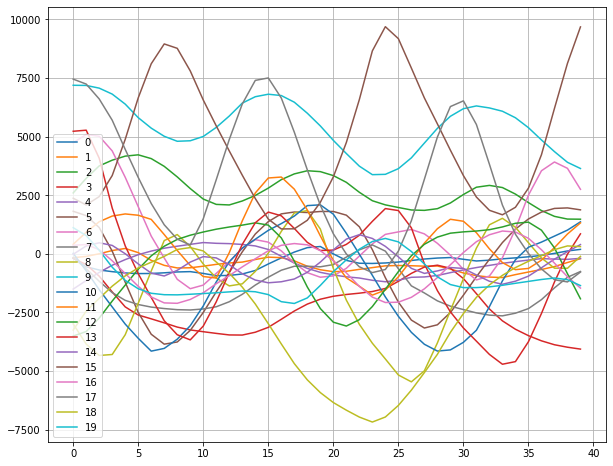

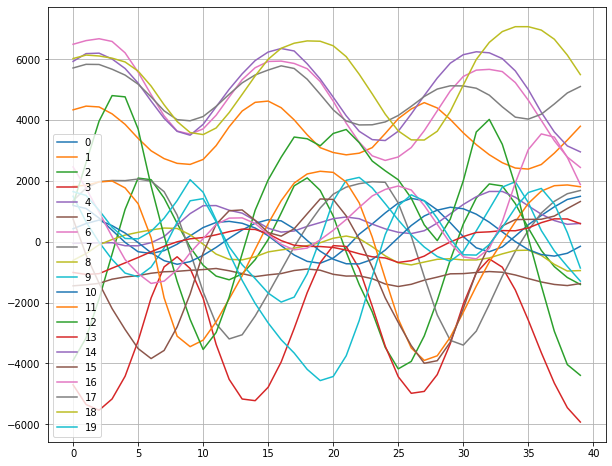

[2600.630637279116, -159.42439644455447, -85.87712025118026, -1712.4431337226392, -4563.9597812863185, 3125.9314041379316]
[3149.783250922798, 2842.4111464370876, 2407.89513671968, 14113.080297058013, 7301.911860195003, 7893.418709374214]
(10523, 40, 6) (1858, 40, 6)


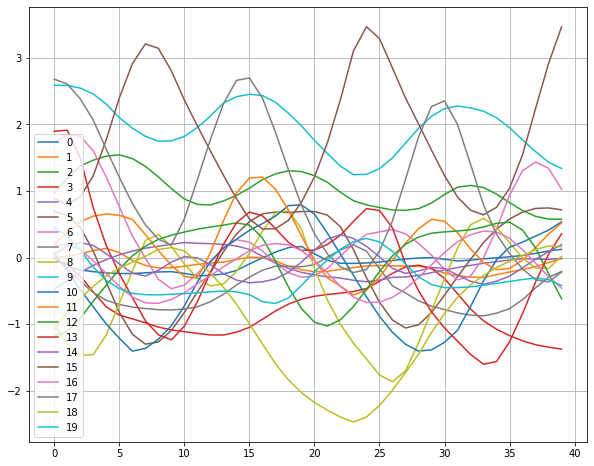

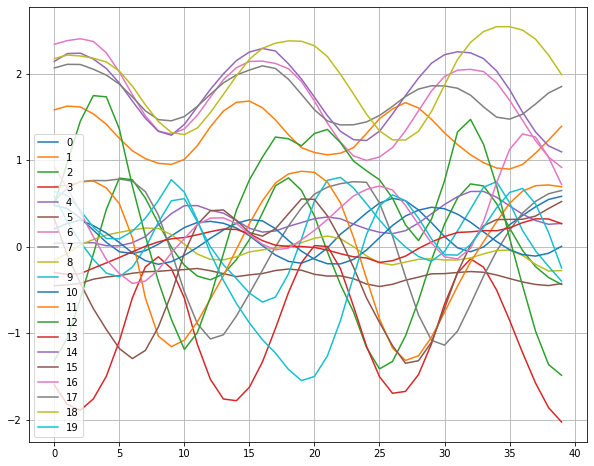

In [ ]:
#对照组1
# fig, ax = plt.subplots(figsize = [10,8])
# for j in range(20):
#   x = [i for i in range(len(train_x[j]))]
#   ax.plot(x, train_x[j][:], label = str(j))
# plt.legend()
# ax.grid()
# plt.show()
# fig, ax = plt.subplots(figsize = [10,8])
# for j in range(20):
#   x = [i for i in range(len(test_x[j]))]
#   ax.plot(x, test_x[j][:], label = str(j))
# plt.legend()
# ax.grid()
# plt.show()

#对比组2
fig, ax = plt.subplots(figsize = [10,8])
for j in range(20):
  x = [i for i in range(len(train_x[j]))]
  ax.plot(x, train_x[j][:, 1], label = str(j))
plt.legend()
ax.grid()
plt.show()
fig, ax = plt.subplots(figsize = [10,8])
for j in range(20):
  x = [i for i in range(len(test_x[j]))]
  ax.plot(x, test_x[j][:, 1], label = str(j))
plt.legend()
ax.grid()
plt.show()

#sklearn组1，先feature extraction, 后rescale
# from sklearn.preprocessing import StandardScaler
# from pickle import dump
# #feature_range=(-1,1)
# scaler = StandardScaler()
# # fit scaler on the training dataset
# scaler.fit(train_x)
# # transform the training dataset
# train_x = scaler.transform(train_x)
# test_x = scaler.transform(test_x)
# print(scaler.mean_)
# print(scaler.scale_)
# print(train_x.shape, test_x.shape)
# fig, ax = plt.subplots(figsize = [10,8])
# for j in range(20):
#   x = [i for i in range(len(train_x[j]))]
#   ax.plot(x, train_x[j][:], label = str(j))
# plt.legend()
# ax.grid()
# plt.show()
# fig, ax = plt.subplots(figsize = [10,8])
# for j in range(20):
#   x = [i for i in range(len(test_x[j]))]
#   ax.plot(x, test_x[j][:], label = str(j))
# plt.legend()
# ax.grid()
# plt.show()

#组2，先rescale，后feature extraction
#feature_range=(-1,1)
scaler = StandardScaler()
# fit scaler on the training dataset
scaler.fit(train_x.reshape(-1, train_x.shape[-1]))
# transform the training dataset
train_x = scaler.transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
test_x = scaler.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)
print(list(scaler.mean_))
print(list(scaler.scale_))
print(train_x.shape, test_x.shape)
fig, ax = plt.subplots(figsize = [10,8])
for j in range(20):
  x = [i for i in range(len(train_x[j]))]
  ax.plot(x, train_x[j][:, 1], label = str(j))
plt.legend()
ax.grid()
plt.show()
fig, ax = plt.subplots(figsize = [10,8])
for j in range(20):
  x = [i for i in range(len(test_x[j]))]
  ax.plot(x, test_x[j][:, 1], label = str(j))
plt.legend()
ax.grid()
plt.show()
dump(scaler, open('/content/drive/MyDrive/temp_models/scaler_11.pkl', 'wb'))

In [ ]:
train_x_fx = []
train_y_fx = []
for i in range(train_x.shape[0]):
  fx_df = train_x[i]
  temp_list = []
  for k in range(feature_n):
      f_n = fx_df[:, k]
      f_n = f_n.reshape(-1)
      f1_mean = compute_mean(f_n)
      f1_var = compute_variance(f_n)
      f1_mad = compute_median_absolute_deviation(f_n)
      f1_rms = compute_root_mean_square(f_n)
      f1_iqr = compute_interquartile_range(f_n)
      f1_per75 = compute_percentile_75(f_n)
      f1_kurtosis = compute_kurtosis(f_n)
      f1_min_max = compute_min_max(f_n)
      f1_sma = compute_signal_magnitude_area(f_n)
      f1_zcr = compute_zero_crossing_rate(f_n)
      f1_sc = compute_spectral_centroid(f_n)
      f1_entropy = compute_spectral_entropy(f_n)
      f1_energy = compute_spectral_energy(f_n)
      f1_pfreq = compute_principle_frequency(f_n)
      temp_list.append(f1_mean)
      temp_list.append(f1_var)
      temp_list.append(f1_mad)
      temp_list.append(f1_rms)
      temp_list.append(f1_iqr)
      temp_list.append(f1_per75)
      temp_list.append(f1_kurtosis)
      temp_list.append(f1_min_max)
      temp_list.append(f1_sma)
      temp_list.append(f1_zcr)
      temp_list.append(f1_sc)
      temp_list.append(f1_entropy)
      temp_list.append(f1_energy)
      temp_list.append(f1_pfreq)
  train_x_fx.append(temp_list)
  train_y_fx.append(train_y[i])
train_x_fx = np.array(train_x_fx)
train_y_fx = np.array(train_y_fx)
print(train_x_fx.shape)
print(train_y_fx.shape)

(10523, 84)
(10523,)


In [ ]:
test_x_fx = []
test_y_fx = []
for i in range(test_x.shape[0]):
  fx_df = test_x[i]
  temp_list = []
  for k in range(feature_n):
      f_n = fx_df[:, k]
      f_n = f_n.reshape(-1)
      f1_mean = compute_mean(f_n)
      f1_var = compute_variance(f_n)
      f1_mad = compute_median_absolute_deviation(f_n)
      f1_rms = compute_root_mean_square(f_n)
      f1_iqr = compute_interquartile_range(f_n)
      f1_per75 = compute_percentile_75(f_n)
      f1_kurtosis = compute_kurtosis(f_n)
      f1_min_max = compute_min_max(f_n)
      f1_sma = compute_signal_magnitude_area(f_n)
      f1_zcr = compute_zero_crossing_rate(f_n)
      f1_sc = compute_spectral_centroid(f_n)
      f1_entropy = compute_spectral_entropy(f_n)
      f1_energy = compute_spectral_energy(f_n)
      f1_pfreq = compute_principle_frequency(f_n)
      temp_list.append(f1_mean)
      temp_list.append(f1_var)
      temp_list.append(f1_mad)
      temp_list.append(f1_rms)
      temp_list.append(f1_iqr)
      temp_list.append(f1_per75)
      temp_list.append(f1_kurtosis)
      temp_list.append(f1_min_max)
      temp_list.append(f1_sma)
      temp_list.append(f1_zcr)
      temp_list.append(f1_sc)
      temp_list.append(f1_entropy)
      temp_list.append(f1_energy)
      temp_list.append(f1_pfreq)
  test_x_fx.append(temp_list)
  test_y_fx.append(test_y[i])
test_x_fx = np.array(test_x_fx)
test_y_fx = np.array(test_y_fx)
print(test_x_fx.shape)
print(test_y_fx.shape)

(1858, 84)
(1858,)


### Train with K-fold since K-fold performs better ###

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)

0it [00:00, ?it/s]

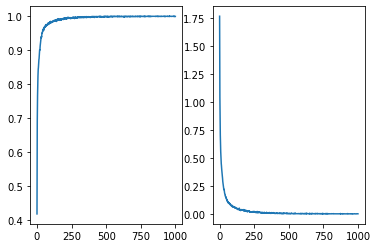

===Highest training accuracy: 1.0===
===Validation accuracy for fold 1: 0.997149646282196; f1_macro is 0.9968189597129822===


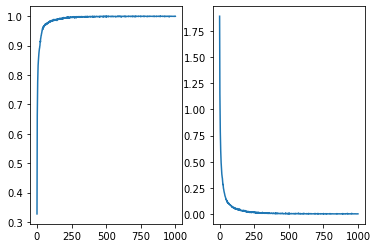

===Highest training accuracy: 1.0===
===Validation accuracy for fold 2: 0.994774341583252; f1_macro is 0.9947394132614136===


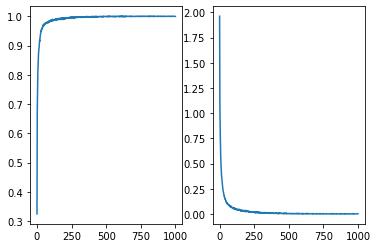

===Highest training accuracy: 1.0===
===Validation accuracy for fold 3: 0.994774341583252; f1_macro is 0.9942877292633057===


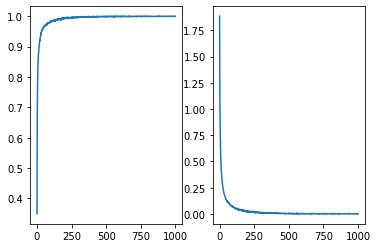

===Highest training accuracy: 1.0===
===Validation accuracy for fold 4: 0.9980988502502441; f1_macro is 0.9979473948478699===


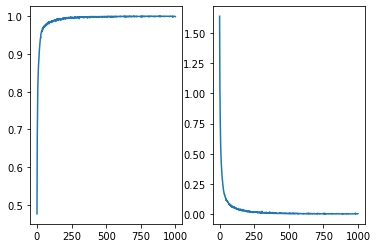

===Highest training accuracy: 1.0===
===Validation accuracy for fold 5: 0.9938212633132935; f1_macro is 0.9935309886932373===
=== K fold cv completed, Best model occured at fold 4, with accuracy 0.9980988502502441, f1 macro 0.9979473948478699===


In [ ]:
num_classes = 9
num_features = 6 * 14
batch_size = 32
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 1000
best_id = 1
best_acc = 0
best_f1_macro = 0
input_shape = (num_features, 1)
save_path = '/content/drive/MyDrive/temp_models'

for train, test in tqdm(kfold.split(train_x_fx, train_y_fx)):
  with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = input_shape),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x_fx[train]
    _train_y = train_y_fx[train]
    _val_x = train_x_fx[test]
    _val_y = train_y_fx[test]
#     print(_train_x.shape)
#     print(_train_y.shape)
#     print(_val_x.shape)
#     print(_val_y.shape)
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    #If feature extraction is used, then the input is 1d array, we need re format for cnn
    _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
    _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=num_classes), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes= num_classes), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs,
        verbose = 0
    )
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    ax1.plot(train_acc)
    ax2.plot(train_loss)
    plt.show()
    print(f"===Highest training accuracy: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_id = fold_no
        best_f1_macro = f1_macro
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_kfold_fx_fold{fold_no}.h5"))
    fold_no += 1
print(f"=== K fold cv completed, Best model occured at fold {best_id}, with accuracy {best_acc}, f1 macro {best_f1_macro}===")

In [ ]:
length_test= test_x_fx.shape[0]
test_x_fx = tf.convert_to_tensor(test_x_fx, dtype=tf.float32)
#Again, we conly need below line if feature extraction is used
test_x_fx = tf.reshape(test_x_fx, (length_test, num_features, 1))
test_y_fx_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y_fx,  num_classes=num_classes), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fx_fold{best_id}.h5"))
y_pred = best_model.predict(test_x_fx, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
for i in range(len(test_y_fx)):
  if test_y_fx[i] != y_pred_1[i]:
    print(test_y_fx[i], y_pred_1[i])
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y_fx, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_fx_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

5 8
1 3
3 5
3 4
0 7
0 5
6 4
1 7
6 1
2 8
test accuracy is 0.9946178793907166
test f1 macro is 0.9943097233772278


In [ ]:
print(best_id)

4


In [ ]:
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 82, 32)            128       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 41, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 39, 32)            3104      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 19, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 17, 32)            3104      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 8, 32)           

## Integration part ##
1. Save the model to tensorflow lite
2. Give the parameters to sanath
3. Note, we should turn on these hyperparameters: window (length), overlap, whether feature extraction is used, whether EMA is used, epoch number(not sure)
4. At the test end, we should vote base on 3 or 5 predictions

In [ ]:
# Using or not using k-fold, the model name differ
# model.save('boing_cnn_tflite.h5')
number = 11
feature_extraction = 'fx'
print(f"/content/drive/MyDrive/temp_models/w13_{number}")
best_model.save(f"/content/drive/MyDrive/temp_models/w13_{number}.h5")
model_cnn_tflite= tf.keras.models.load_model(f"/content/drive/MyDrive/temp_models/w13_{number}.h5")
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_tflite)
tflite_model = converter.convert()
with open(f"/content/drive/MyDrive/temp_models/w13_{number}.tflite", 'wb') as f:
    f.write(tflite_model)

/content/drive/MyDrive/temp_models/w13_11
INFO:tensorflow:Assets written to: /tmp/tmpzu6lb6ca/assets


In [ ]:
# Different from noraml evluation, here we test the tflite file with a single input.
# if successful, the funciton can be moved to ultra96, we can call the ML model in ultra96.

# import tflite_runtime.interpreter as tflite
#   train_max = np.array([13811.398022174102, 12787.0, 13248.064922600952, 31375.91863600317, 31282.245750364258, 30620.470452529367])
#   train_min = np.array([-19497.0, -13754.671778742177, -13921.091173480494, -31337.872619438287, -31240.316963619214, -31082.2])
#   input_data_std = (input_data - train_min) / (train_max - train_min)
#   #X_scaled = X_std * (max - min) + min
#   input_data = input_data_std * 1
#   input_data = input_data.astype('float32')
import time
from math import exp
from pickle import load

def math_loser(input_data, model_path, rescale=True):
    interpreter = tf.lite.Interpreter(model_path= model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # check the type of the input tensor
    floating_model = input_details[0]['dtype'] == np.float32
    if rescale:
      input_data = scaler.transform(input_data)
    # NxHxWxC, H:1, W:2
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    input_data = np.reshape(input_data, (-1, height, width))
    interpreter.set_tensor(input_details[0]['index'], input_data)
    start_time = time.time()
    interpreter.invoke()
    stop_time = time.time()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    results = np.squeeze(output_data)
    sum_probability = exp(results[0]) + exp(results[1]) + exp(results[2])
     + exp(results[3]) + exp(results[4])  + exp(results[5]) + exp(results[6])
      + exp(results[7]) + exp(results[8]) 
    p1 = exp(results[0]) / sum_probability
    p2 = exp(results[1]) / sum_probability
    p3 = exp(results[2]) / sum_probability
    p4 = exp(results[3]) / sum_probability
    p5 = exp(results[4]) / sum_probability
    p6 = exp(results[5]) / sum_probability
    p7 = exp(results[6]) / sum_probability
    p8 = exp(results[7]) / sum_probability
    p9 = exp(results[8]) / sum_probability
    prob_list = [p1,p2,p3,p4,p5,p6,p7,p8,p9]
    pred = np.argmax(results)
    #print('time used: {:.3f}ms'.format((stop_time - start_time) * 1000))
    return pred, prob_list

In [ ]:
correct = 0
total = 0
correct_1 = 0
total_1 = 0
# print(list(train_max))
# print(list(train_min))
scaler = load(open('/content/drive/MyDrive/temp_models/scaler_11.pkl', 'rb'))
for i in range(len(test_y)):
  with open(f"test/test_single_y_{window}_{i}.txt", 'r') as f:
    _y = f.readline().strip()
  _input_data = pd.read_csv(f"test/test_single_x_{window}_{i}.csv", index_col=False)
  _input_data = _input_data.to_numpy()
  if feature_extraction == 'fx':
    #_input_data = np.reshape(_input_data, (-1, _input_data.shape[0]))
    _input_data = scaler.transform(_input_data)
    fx_df = _input_data
    temp_list = []
    for k in range(feature_n):
        f_n = fx_df[:, k]
        f_n = f_n.reshape(-1)
        f1_mean = compute_mean(f_n)
        f1_var = compute_variance(f_n)
        f1_mad = compute_median_absolute_deviation(f_n)
        f1_rms = compute_root_mean_square(f_n)
        f1_iqr = compute_interquartile_range(f_n)
        f1_per75 = compute_percentile_75(f_n)
        f1_kurtosis = compute_kurtosis(f_n)
        f1_min_max = compute_min_max(f_n)
        f1_sma = compute_signal_magnitude_area(f_n)
        f1_zcr = compute_zero_crossing_rate(f_n)
        f1_sc = compute_spectral_centroid(f_n)
        f1_entropy = compute_spectral_entropy(f_n)
        f1_energy = compute_spectral_energy(f_n)
        f1_pfreq = compute_principle_frequency(f_n)
        temp_list.append(f1_mean)
        temp_list.append(f1_var)
        temp_list.append(f1_mad)
        temp_list.append(f1_rms)
        temp_list.append(f1_iqr)
        temp_list.append(f1_per75)
        temp_list.append(f1_kurtosis)
        temp_list.append(f1_min_max)
        temp_list.append(f1_sma)
        temp_list.append(f1_zcr)
        temp_list.append(f1_sc)
        temp_list.append(f1_entropy)
        temp_list.append(f1_energy)
        temp_list.append(f1_pfreq)
    _input_data = np.array(temp_list)
  _input_data = _input_data.astype('float32')
  # if _y != test_y[i]:
  #   print("wrongle")
  pred, prob_list = math_loser(_input_data, f"/content/drive/MyDrive/temp_models/w13_{number}.tflite",rescale=False)
  if pred == int(_y):
    correct += 1
  total += 1
  pred_2, _ = math_loser(test_x_fx[i], f"/content/drive/MyDrive/temp_models/w13_{number}.tflite", rescale=False)
  if pred_2 == test_y_fx[i]:
    correct_1 += 1
  total_1 += 1
  # print(pred, _y)
  # print(pred_2, test_y[i])
  # print(prob_list)
  # break
print(correct / total)
print(correct_1/total_1)
print(total)
print(correct)

0.9946178686759957
0.9946178686759957
1858
1848


In [ ]:
with open(f"test/test_single_y_{window}_20.txt", 'r') as f:
    _y = f.readline().strip()
print(f"correct label: {_y}")
_input_data = pd.read_csv(f"test/test_single_x_{window}_20.csv", index_col=False)
# _input_data=(_input_data-_input_data.mean())/_input_data.std()
# print(list(_input_data.columns))
if feature_extraction == 'fx':
    temp_list = []
    for k in range(0, 6):
      f_n = _input_data[str(k)].to_numpy()
      f_n = f_n.reshape(-1)
      print(f_n.shape)
      print(f_n)
      f1_mean = compute_mean(f_n)
      f1_var = compute_variance(f_n)
      f1_mad = compute_median_absolute_deviation(f_n)
      f1_rms = compute_root_mean_square(f_n)
      f1_iqr = compute_interquartile_range(f_n)
      f1_per75 = compute_percentile_75(f_n)
      f1_kurtosis = compute_kurtosis(f_n)
      f1_min_max = compute_min_max(f_n)
      f1_sma = compute_signal_magnitude_area(f_n)
      f1_zcr = compute_zero_crossing_rate(f_n)
      f1_sc = compute_spectral_centroid(f_n)
      f1_entropy = compute_spectral_entropy(f_n)
      f1_energy = compute_spectral_energy(f_n)
      f1_pfreq = compute_principle_frequency(f_n)
      temp_list.append(f1_mean)
      temp_list.append(f1_var)
      temp_list.append(f1_mad)
      temp_list.append(f1_rms)
      temp_list.append(f1_iqr)
      temp_list.append(f1_per75)
      temp_list.append(f1_kurtosis)
      temp_list.append(f1_min_max)
      temp_list.append(f1_sma)
      temp_list.append(f1_zcr)
      temp_list.append(f1_sc)
      temp_list.append(f1_entropy)
      temp_list.append(f1_energy)
      temp_list.append(f1_pfreq)
    temp_list = np.array(temp_list)
    print(temp_list.shape)
    temp_list = temp_list.astype('float32')
    print(f"shape of the input we passed in initially is {temp_list.shape}")
    print(f"type of the input we passed in is {temp_list.dtype}")
    pred,problist = math_loser(temp_list, f"/content/drive/MyDrive/temp_models/w13_{number}.tflite")
else:
    _input_data = _input_data.to_numpy()
    _input_data = _input_data.astype('float32')
    print(f"shape of the input we passed in initially is {_input_data.shape}")
    print(f"type of the input we passed in is {_input_data.dtype}")
    pred,problist = math_loser(_input_data, f"/content/drive/MyDrive/temp_models/w13_{number}.tflite")
    print(f"printed to {pred}")

correct label: 0
(84,)
[ 2.20590368e+03  1.35677754e+06  1.63223425e+03  2.49455178e+03
  2.35776415e+03  3.39784095e+03 -1.45300735e+00  3.49720592e+03
  2.20590368e+03  0.00000000e+00  8.15286764e-02  9.45441922e-01
  1.34910938e+15  7.50000000e-02 -4.18145347e+02  1.72755358e+05
  4.69569865e+02  5.89576873e+02  6.73534847e+02 -6.94973496e+01
 -8.78163012e-01  1.45739179e+03 -4.18145347e+02  3.00000000e+00
  1.72530469e-01  1.47176171e+00  5.46998033e+12  7.50000000e-02
  1.19540619e+03  1.13848200e+06  1.53746058e+03  1.60233516e+03
  2.06505368e+03  2.26257822e+03 -1.53774202e+00  3.00560941e+03
  1.19540619e+03  6.00000000e+00  1.28279900e-01  9.32713932e-01
  8.70364963e+14  7.50000000e-02 -3.08036220e+03  6.54236539e+03
  8.76671835e+01  3.08142396e+03  9.66182907e+01 -3.04800328e+03
 -5.33189346e-01  3.15283000e+02 -3.08036220e+03  0.00000000e+00
  1.87999978e-02  9.93775374e-01  9.55769122e+08  2.50000000e-02
 -7.32578831e+03  1.94799345e+05  4.62168070e+02  7.33907172e+03
  

KeyError: ignored

In [ ]:
def print_conv_kernel(np_arr):
    # Conv Layer (Kernel)
    print("{")
    first_3 = True
    for filter in np_arr:
        if first_3 == False:
            print(",", end="")
        first_3 = False
        print("{",end="")
        first = True
        for row in filter:
            if first == False:
                print(",", end="")
            print("{" , end="")
            first = False

            first_2 = True
            for val in row:
                if first_2 == False:
                    print(",", end="")
                print(val , end="")
                first_2 = False
            print("}")
        print("}")
        print()
    print("};")

def print_dense_layer_kernel(np_arr):
    # Dense Layer (Kernel)
    print("{")
    first_3 = True
    for filter in np_arr:
        if first_3 == False:
            print(",", end="")
        first_3 = False
        print("{",end="")
        first_2 = True
        for val in filter:
            if first_2 == False:
                print(",", end="")
            print(val , end="")
            first_2 = False
        print("}")
    print("};")
    
def print_bias(np_arr):
    # Bias (both conv & dense)
    print("{",end="")
    first = True
    for val in np_arr:
        if first == False:
            print(",",end="")
        first = False
        print(val,end="")
    print("};")

best_model = tf.keras.models.load_model(f"/content/drive/MyDrive/temp_models/w13_{number}.h5")
# Extract Conv Layer Weights
# Conv Layer 1
print_conv_kernel(best_model.trainable_weights[0].numpy())
print_bias(best_model.trainable_weights[1].numpy())

# Conv Layer 2
print_conv_kernel(best_model.trainable_weights[2].numpy())
print_bias(best_model.trainable_weights[3].numpy())

# Conv Layer 3
print_conv_kernel(best_model.trainable_weights[4].numpy())
print_bias(best_model.trainable_weights[5].numpy())

# Extract Dense Layer Weights
# Dense Layer 1
print_dense_layer_kernel(best_model.trainable_weights[6].numpy())
print_bias(best_model.trainable_weights[7].numpy())

# Dense Layer 2
print_dense_layer_kernel(best_model.trainable_weights[8].numpy())
print_bias(best_model.trainable_weights[9].numpy())

In [ ]:
scaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}